### imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier



# first glance

In [ ]:
data = pd.read_csv('train.csv')
data.head()

In [ ]:
data.iloc[:,1:].hist(figsize=(12,10))
pass

In [ ]:
corr = data.corr()
sb.heatmap(corr)
pass

we can see durations are linked

# exploration and preprocessing
1. split data
2. Convert non-numeric features to numeric/dummy
3. Fill out missing values


### split data

In [ ]:
Y = data.loc[:,'purchase'] 
X = data.iloc[:, :-1]

X_train, X_val, y_train, y_val = train_test_split(X, Y,test_size=0.8,random_state=23)

print('y value couns:\n',y_train.value_counts(), sep='')
del X, Y
X_train.head(5)


In [ ]:
print("** types: **")
print(X_train.dtypes)

print('\n** label values: **\n',y_train.value_counts())
print(f'purchased sessions are around {int((y_train.loc[y_train == 1].shape[0] / y_train.shape[0]) * 100)}% of all sessions')

## id
id is probelbly usless for us

In [ ]:
def id_prep(X):
    X = X.drop(columns=['id'])
    return X

X_val = id_prep(X_val)
X_train = id_prep(X_train)

### page durations

In [ ]:
## convert to numeric


def page_durations_prep(X):
    fields = ['info_page_duration', 'product_page_duration']
    for field in fields:
        print(field, 'str structure:', X[field].value_counts().index[0])

        # make sure all durations are in minutes
        print('not minutes count: ', len(X.loc[~X[field].str.contains('minutes').astype('bool'),(field)]))
        print('nan count: ', X[field].isnull().sum())

        # convert to float `type(d)==str ` handles nan values
        X[field] = [float(d.split()[0]) if type(d) is str else np.nan for d in X[field]]

        print('new types:')
        X.dtypes[fields]

    return X

print('train:')
X_train = page_durations_prep(X_train)
print('test:')
X_val = page_durations_prep(X_val)






In [ ]:
## fill missing vlaues
avg_time_in_admin_page = (X_train.admin_page_duration / X_train.num_of_admin_pages).mean()
avg_time_in_info_page = (X_train.info_page_duration / X_train.num_of_info_pages).mean()
avg_time_in_product_page = (X_train.product_page_duration / X_train.num_of_product_pages).mean()

avgs = (avg_time_in_info_page, avg_time_in_product_page, avg_time_in_admin_page)

def page_durations_fill_na(X):
    
    duration_fields = ('info_page_duration', 'product_page_duration', 'admin_page_duration')
    num_of_fields = ('num_of_info_pages', 'num_of_product_pages','num_of_admin_pages')
    for i, field in enumerate(duration_fields):        
        num_of_field_copy = X[num_of_fields[i]].copy()
        num_of_field_copy = num_of_field_copy.fillna(num_of_field_copy.mean())
        X.loc[X[field].isna(), field] = avgs[i] * num_of_field_copy.loc[X[field].isna()]
    return X

X_train = page_durations_fill_na(X_train)
X_val = page_durations_fill_na(X_val)

### total durations
on the one hand `total duration` has many nan values, on the other hand it is easy enough to calculate it. so we decided to keep it and fill the nans

In [ ]:

def total_druation_data_prep(X):
    ## total duration
    computed_durations = X.admin_page_duration + X.info_page_duration + X.product_page_duration
    X.total_duration = X.total_duration.fillna(computed_durations)
    return X

X_train = total_druation_data_prep(X_train)
X_val = total_druation_data_prep(X_val)


In [ ]:
X_train.info_page_duration.loc[X_train.info_page_duration.isnull()]

### num of page visits

In [ ]:
# fill missing values
avgs = (avg_time_in_info_page, avg_time_in_product_page, avg_time_in_admin_page)

def num_of_visits_data_prep(X: pd.DataFrame):
    duration_fields = ('info_page_duration', 'product_page_duration', 'admin_page_duration')
    num_of_fields = ('num_of_info_pages', 'num_of_product_pages','num_of_admin_pages')
    for i, field in enumerate(num_of_fields):
        X.loc[X[field].isna(), field] = [ int(value / avgs[i]) for value in X.loc[X[field].isna(), duration_fields[i]]]
    return X


X_train = num_of_visits_data_prep(X_train)
X_val = num_of_visits_data_prep(X_val)

### user type
user type has mainly two values, `New_Visitor` and  `Returning_Visitor`.
We wanted to see if we can map it to a binary feature.
For this, we:
1. made sure that `nan` and `other` are very rare
2. made sure there is no strong correlation between `other` and the label or featrue.

In [ ]:
# check values
vc = X_train.user_type.value_counts()
nan_count = X_train.user_type.isnull().sum()
print('original user type values:\n', vc)
print('nan count        :', nan_count)
print('\n`other` categoryh is only ', f"{round(vc['Other'] / X_train.shape[0] * 100, 2)}%", 'of the data')
print('`Returning_Visitor` categoryh is ', f"{round(vc['Returning_Visitor'] / X_train.shape[0] * 100, 2)}%", 'of the data')
print('nan values are only ', f"{round(nan_count / X_train.shape[0] * 100, 2)}%", 'of the data')



explore correlations betwenn user type and other features

In [ ]:
X_train_user_dummy = pd.get_dummies(X_train,columns=['user_type'], prefix_sep='_dmy_', drop_first=False)

In [ ]:
sb.heatmap(X_train_user_dummy.corr()[16:19].T[:16])

In [ ]:

X_train.loc[X_train.user_type == 'Other', ('device')].value_counts().plot.bar(color=['#F9AB42']+['#7DC9ED']*2,
 title="devices of 'other' users", xlabel='devices')
plt.show()
devices_all = X_train.device.value_counts()
i = np.where(devices_all.index == 8.0)[0][0]
clrs = ['#7DC9ED']*7
clrs[i] = "#F9AB42"
devices_all.plot.bar(color=clrs,
 title="devices of all users", xlabel='devices')
plt.show()

### user_type - conclusion
two interesting correlartion here:  
a. `device` and `Other`:   
altough device 8 is very rare, almost all of device 8 sessions are `other`.  
It may mean that device 8 has some bug when collecing `user_type` data. However for our purpose it is not helpful (We were looking for a way to turn "other" to one of the other two.)  
b. `D`. but since `D` is mostly missing values, We shall treat `user type` as binary: only new users (0) and returing users (1)

In [ ]:
#  map 'Returning_Visitor' , missing value and  'other' to 1, and New_Visitor to 0

def user_type_data_prep(X):
    RETURNING ='Returning_Visitor'
    X.user_type = [1 if u_type == RETURNING else 0 for u_type in X.user_type] 
    return X

X_train = user_type_data_prep(X_train)
X_val = user_type_data_prep(X_val)




## D
d's seem to have mostly nan values
If it's lower than 10%, we will remove it altogether

In [ ]:
valid_ds = X_train.loc[~np.isnan(X_train.D)]
print('only', str((valid_ds.shape[0] / X_train.shape[0]) * 100)[:3], "% of D's have values")

def d_data_prep(X):
    # remove D feature        
    return X.drop(columns=('D'))
del valid_ds

X_train = d_data_prep(X_train)
X_val = d_data_prep(X_val)


## Bounce rate,  Exit rate, Page value

In [ ]:
print('BounceRates nan count:', X_train.BounceRates.isnull().sum())
print('ExitRates nan count:', X_train.ExitRates.isnull().sum())
print('page values nan count:', X_train.PageValues.isnull().sum())

def rates_page_value_data_prep(X):    
    # so little nan values - lets fill with mean
    X.BounceRates = X.BounceRates.fillna(X_t.BounceRates.mean())
    X.ExitRates = X.ExitRates.fillna(X_t.ExitRates.mean())
    X.PageValues = X.PageValues.fillna(X_t.PageValues.mean())
    return X


X_train = rates_page_value_data_prep(X_train)
X_val= rates_page_value_data_prep(X_val)


## closeness to holiday

In [ ]:
print('closeness_to_holiday nan caount:', X_train.closeness_to_holiday.isnull().sum())
corr = X_train.corr()
sb.heatmap(corr.iloc[11:12].T[corr.columns != 'closeness_to_holiday'])
pass



In [ ]:

figure, axes = plt.subplots(1,2)
figure.set_size_inches((12,3))
for axe, yi in zip(axes, (0,1)):
    axe.hist(X_train.closeness_to_holiday[y_train ==yi])
    axe.set_title(f'closeness to holiday when y={yi}')
plt.show()



In [ ]:
figure, axes = plt.subplots(1,2)
figure.set_size_inches((12,3))
for axe, yi in zip(axes, (0,1)):
    axe.hist(X_train.closeness_to_holiday[(y_train ==yi) & X_train.closeness_to_holiday != 0.0])
    axe.set_title(f'closeness to holiday when y={yi}, without zero values')
plt.show()


we didnt found any intersting correlataions, using mean

In [ ]:
def closeness_data_prep(X, X_t):    
    X.closeness_to_holiday = X.closeness_to_holiday.fillna(X_t.closeness_to_holiday.mean())
    return X

X_train = closeness_data_prep(X_train)
X_val = closeness_data_prep(X_val)


## Device

In [ ]:
X_train.device.value_counts()


In [ ]:
def make_dummy_device(X: pd.DataFrame):
    mapper = {1.0: '1', 2.0: '2', 3.0: '3', 'Default': 'other'}
    X.device = [mapper.get(d, mapper['Default']) for d in X.device]    
    return pd.get_dummies(data=X, columns=['device'], drop_first=False, prefix_sep='_dmy_')
    
X_train = make_dummy_device(X_train)
X_val = make_dummy_device(X_val)

In [ ]:
X_train.columns

In [ ]:
X_train.C.value_counts()

In [ ]:

def make_dummy_C(X: pd.DataFrame):
    def extract_num(s):   
        if s is np.nan:
             return s
        for indx, chr in enumerate(s):
            if str.isdigit(chr):
                break
        return s[indx:]
    X.C = [extract_num(c) for c in X.C]

    return pd.get_dummies(data=X, columns=['C'], drop_first=False, prefix_sep='_dmy_')
    

X_train = make_dummy_C(X_train)
X_val = make_dummy_C(X_val)

## weekand

In [ ]:
X_train.Weekend.value_counts()

In [ ]:

def weekend_data_prep(X):
    X.Weekend = [1 if w else 0 for w in X.Weekend]
    return X

X_train = weekend_data_prep(X_train)
X_val = weekend_data_prep(X_val)
X_train.Weekend.value_counts()



## B

In [ ]:
print("B nan count:", X_train.B.isnull().sum())
def b_data_prep(X):
    global X_train
    X.B = X.B.fillna(X_train.B.mean())
    return X

X_train = b_data_prep(X_train)
X_val = b_data_prep(X_val)

print("B nan count after filling - train:", X_train.B.isnull().sum())
print("B nan count after filling - test:", X_val.B.isnull().sum())




## browser

In [ ]:
X_train.internet_browser = X_train.internet_browser.str.replace('\d+', '')
X_train['internet_browser'] = X_train['internet_browser'].astype(str).str.extract(r'([A-Za-z]+(?: [A-Za-z]+)*)')

X_val.internet_browser = X_val.internet_browser.str.replace('\d+', '')
X_val['internet_browser'] = X_val['internet_browser'].astype(str).str.extract(r'([A-Za-z]+(?: [A-Za-z]+)*)')

print(X_train.internet_browser.value_counts())

# corr = X_train.corr()
# sb.heatmap(corr.iloc[8:15].T[corr.columns != 'internet_browser'])


# X_train.internet_browser = ['Other' if i == 'nan' else X_train.internet_browser]


In [ ]:
X_train_browser_dummy = pd.get_dummies(X_train,columns=['internet_browser'],drop_first=False, prefix_sep='_dmy_')

In [ ]:
corr = X_train_browser_dummy.corr()
plt.figure(figsize=(8,6))
sb.heatmap(corr.iloc[16:].T[~corr.columns.str.startswith('internet_browser')])


In [ ]:
X_train

### fill na - browser
we can see there's a link between device and browswer, device 1 linked to safari (probelbly iphone/mac?) and devices 2 and 3 linked to chrome.

In [ ]:

def browser_data_prep(X: pd.DataFrame):
    global X_train
    X = pd.get_dummies(X,columns=['internet_browser'],drop_first=False, prefix_sep='_dmy_')    


    # device 1 means safari
    X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_1 > 0), ('internet_browser_dmy_safari',)] = 1

    # device 2/3 means chrome
    X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_2 + X.device_dmy_3  > 0), ('internet_browser_dmy_chrome',)] = 1

    print(X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_other == 1)].shape[0], ' nan values left. we shall fill it with chrome - chrome is the most common')

    # # fill with chrome
    X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_other == 1), 'internet_browser_dmy_chrome'] = 1

    # make sure no nan left 
    print(X.loc[(X.internet_browser_dmy_nan == 1) & ((X.internet_browser_dmy_chrome + X.internet_browser_dmy_safari) < 1)].shape[0], ' nan values left.')

    # drop nan dummy
    return X.drop(columns=['internet_browser_dmy_nan'])

X_train = browser_data_prep(X_train)
X_val = browser_data_prep(X_val)

    

## month
divide to 4 yearly quarters

In [ ]:
def month_data_prep(X):
     Month_map = {'JAN':1, 'Feb':1, 'Mar':1, 'APR':2, 'May':2, 'June':2, 'Jul':3, 'Aug':3, 'Sep':3, 'Oct':4, 'Nov':4, 'Dec':4}
     X.Month = X.Month.map(Month_map)
     X.Month = X.Month.fillna(X_train.Month.median())
     return X

X_train = month_data_prep(X_train)
X_val = month_data_prep(X_val)
X_train.Month.value_counts()


## Region

In [ ]:
print(X_train.Region.value_counts())
print('nan count before:', X_train.Region.isnull().sum())

# fill nan with median
def region_data_prep(X_t, X: pd.DataFrame):
    train_median = np.median(X_t.Region[~X_t.Region.isnull()])
    X.Region = X.Region.fillna(train_median)
    return X

c = X_train.copy()
c = region_data_prep(X_train, c)
X_train = region_data_prep(X_train, X_train)
X_val = region_data_prep(X_train, X_val)

print('nan count after:', X_train.Region.isnull().sum())



## A feature

In [ ]:
t1 = X_train.A[[str(a).split('_').__len__() == 2 for a in X_train.A]]
t2 = X_train.A[[str(a).split('_').__len__() > 2 for a in X_train.A]]
print('type 1:',t1.iloc[0:5])
print('count', t1.shape[0])

print('\ntype 2:\n', t2.iloc[0:5])
print('count', t2.shape[0])


In [ ]:
print('type 1 describe:')
pd.Series([float(str(a).split('_')[1]) if str(a).split('_').__len__() == 2 else np.nan for a in X_train.A]).describe()


since max is now 19, seems reasonble to use the `c_xx_??` type as `xx`  
this way we can transfer all using `.split('_')[1]`

In [ ]:
X_train.A = [np.nan if a is np.nan else float(str(a).split('_')[1]) for a in X_train.A]
X_val.A = [np.nan if a is np.nan else float(str(a).split('_')[1]) for a in X_val.A]

X_train.A.hist()


In [ ]:
print('nan count:', X_train.A.isna().sum())

In [ ]:
corr = X_train.corr()
sb.heatmap(corr[corr.columns == 'A'].T)
pass

since the distribution decreases left to rihgt - we will fill na with median.

In [ ]:
def a_data_prep(X, X_t):
    train_median = np.median(X_t.A[~X_t.A.isnull()])
    X.A = X.A.fillna(train_median)
    #X.A[X.A.isnull()] = train_median
    return X

X_train = a_data_prep(X_train, X_train)
X_val = a_data_prep(X_val, X_train)

X_train.A.hist()

print('nan count after filling - train:', X_train.A.isnull().sum())
print('nan count after filling - test:', X_val.A.isnull().sum())


In [ ]:
X_val.A

# Outlier removal and normalization

min max normalization is sensative to ourliers

In [ ]:
X_train.loc[:, ~X_train.columns.str.contains('_dmy_')].hist(figsize=(18,14))

pass

B looks very much like normal distribution. we will use it

In [ ]:

def outlier_removal(X, X_t):
    column_mask = (~X.columns.str.contains('_dmy_') & ~X.columns.isin(['user_type', 'Weekend', 'Month', 'B']))
    max_trashold = X.loc[:,column_mask].quantile(q=0.95)
    min_trashold = X.loc[:,column_mask].quantile(q=0.05)

    no_outliers =  X.loc[:,column_mask]

    outlier_mask = ((no_outliers < min_trashold) | (no_outliers > max_trashold)).any(axis=1)

    mean = X_t.loc[:,column_mask].mean(axis=0).values.reshape(1,13)

    X.loc[outlier_mask,column_mask] = mean
    return X

X_train = outlier_removal(X_train, X_train)
X_val = outlier_removal(X_val, X_train)

In [ ]:
X_train.loc[:, ~X_train.columns.str.contains('_dmy_')].hist(figsize=(18,14))


In [ ]:
des = X_train.describe()
std = des.loc[des.index == 'std']
std.iloc[:,0:20]


In [ ]:
std.iloc[:,20:]


In [ ]:
del std, des 

In [ ]:
duration_treshold = 30
print("users who purchesed after less then 30 seconds:", y_train[X_train['total_duration'] < duration_treshold].sum())
print(f'number of users under {duration_treshold} seconds:', X_train.loc[X_train['total_duration'] < duration_treshold].shape[0])

In [ ]:
X_train

### standarization

In [ ]:
noraml_features = ['B']
dummy_features = [f for f in X_train.columns if ('_dmy_' in f)]
X_train.loc[:,~X_train.columns.isin(dummy_features + noraml_features)]

In [ ]:
noraml_features = ['B']
dummy_features = [f for f in X_train.columns if ('_dmy_' in f)]

def features_scaling(X):
    # standard_scaler = StandardScaler()
    minmax_scalar = MinMaxScaler()
    # standard_scaler.fit(X_train.loc[:,noraml_features])
    # minmax_mask = ~X.columns.isin(dummy_features + noraml_features)
    minmax_mask = ~X.columns.isin(dummy_features)
    minmax_scalar.fit(X.loc[:,minmax_mask])

    # X.loc[:,noraml_features] = standard_scaler.transform(X.loc[:,noraml_features])
    X.loc[:,minmax_mask] = minmax_scalar.transform(X.loc[:,minmax_mask])

    return X 

X_train = features_scaling(X_train)
X_val = features_scaling(X_val)
X_train

In [ ]:
def validate_data_prep(X):
    print(X.isna().sum().max() == 0)
    print(np.all(X_train.max() <= 1))
    print(np.all(X_train.min() >= 0))

validate_data_prep(X_train)
validate_data_prep(X_val)

# Models !

generic kfold validation function

In [ ]:
from types import FunctionType

def validate_model(all_data, all_labels, model, model_name, num_folds=10):
    # 0.5 auc line
    baseline = [0,1]
    plt.plot(baseline, baseline, color='black', linestyle=':')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    


    # fpr would be the x axis. this is to calc mean auc between all iterations
    fpr_all_values = np.linspace(0,1,100) 
    tpr_sum = np.array([0.0]*100) 
    auc_sum = 0

    for train_mask, val_mask in KFold(num_folds, shuffle=True, random_state=13).split(X=all_data, y=all_labels):
        xt = all_data.iloc[train_mask] # x train
        xv = all_data.iloc[val_mask] # x validation
        yt = all_labels.iloc[train_mask] # y train
        yv = all_labels.iloc[val_mask] # y validation
        
        model.fit(xt, yt)

        fpr, tpr, thresholds = roc_curve(yv, model.predict_proba(xv)[:,1])
        plt.plot(fpr, tpr, color='lightpink')
        tpr_sum += np.interp(fpr_all_values, fpr, tpr)
        auc_sum += roc_auc_score(yv, model.predict_proba(xv)[:,1])
            

    plt.plot(fpr_all_values, tpr_sum / num_folds , color='darkred')
    plt.title(f'{model_name} result. AUC={round(auc_sum / num_folds, 5)}')
    


def auc_score(model, xv, yv):
    return max(
            roc_auc_score(yv, model.predict_proba(xv)[:,i])
            for i in (0,1))

def accuracy_score(model,xv,yv):
    return model.score(xv, yv)

def plot_scores(model_class, arg_name:str, arg_values:list,
            other_args:dict = None, xt=X_train, xv=X_val,
            yt=y_train, yv=y_val, tuple_index=0,
            scoring:FunctionType = auc_score):
    """ for example knn: plot_score()"""
    print(f'calculating and plotting scores for {model_class.__name__}:')
    multiplot = False
    d = other_args or {} 
    scores = []
    best = 0
    for i, value in enumerate(arg_values):
        print(f'progress: [{int((i / len(arg_values)) * 100)}%]\r', end='')
        d[arg_name] = value
        model = model_class(**d)
        model.fit(xt, yt)
        if not hasattr(scoring, '__iter__'):
            scores.append(scoring(model, xv, yv))
        else:
            multiplot = True
            current_scores = []
            for score in scoring:
                current_scores.append(score(model,xv,yv))
            scores.append(current_scores)
    
   
    values = None
    # spaciel case for nural networks
    if type(tuple_index) is int:
        values = [i[tuple_index] for i in arg_values]
    elif type(tuple_index) is str:
        values = [float(i[1]) + i[0] / 100 for i in arg_values] 
    else:
        values = arg_values      


    # plotting
    if multiplot:
        figure, axes = plt.subplots(1,len(scoring))
        figure.set_size_inches((12,4))
        func_name_prefix = 'set_'
        scores = np.array(scores).T
        best_is = scores.argmax(axis=1)
        best = [(arg_values[best_index], scores[score_idnex][best_index]) for score_idnex, best_index in enumerate(best_is)]
    else:
        best_i = np.argmax(scores)
        best = arg_values[best_i], scores[best_i] 
        axes = [plt]
        scoring = [scoring]
        func_name_prefix = ''
        scores = [scores]

    for i,axe in enumerate(axes):
        axe.scatter(values, scores[i])
        axe.__getattribute__ (func_name_prefix+'ylabel')(scoring[i].__name__)
        axe.__getattribute__ (func_name_prefix+'xlabel')(arg_name)
        axe.__getattribute__(func_name_prefix+'title')(f'{scoring[i].__name__} for {model_class.__name__}')
    print(f'DONE. best score:{best[1]} achived by: {best[0]}')
    return best


combine all data

In [ ]:
all_data = pd.concat([X_train, X_val])
all_labels = pd.concat([y_train, y_val])

## logistic regression

## K-nn 
 

In [ ]:

ns = [n for n in range(1,80,5)]

# plot_auc(KNeighborsClassifier, 'n_neighbors',ns)




seems the right number of neighbors would be around []. we'll let `GridSearch` decide the exact value

In [ ]:
ns = [i for i in range(15,40,1)]
cross_valudation = GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=50, ), param_grid={'n_neighbors': ns}, scoring='roc_auc')
cross_valudation.fit(all_data, all_labels)
best_n = cross_valudation.best_estimator_.n_neighbors

print("chosen number of neighbors:", best_n)
model = KNeighborsClassifier(n_neighbors=best_n)



In [ ]:
validate_model(all_data, all_labels, model, 'KNN')

the mean of a 340 cluster giver 0.67 auc

# Multi-Layer Perceptron

In [18]:
model = MLPClassifier(hidden_layer_sizes=(190,6), max_iter=100, solver='sgd',
                        tol=10**-6,random_state=12, learning_rate_init=0.01, alpha=0.1, learning_rate='adaptive')

model.fit(X_train, y_train)
auc1 = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
auc2 = roc_auc_score(y_val, model.predict_proba(X_val)[:,0])
max(auc1, auc2)


0.5

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(25,10), max_iter=100, solver='sgd',
                        tol=10**-6,random_state=12, learning_rate_init=1,
                         alpha=0.01, learning_rate='adaptive')

model.fit(X_train, y_train)
auc1 = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
auc2 = roc_auc_score(y_val, model.predict_proba(X_val)[:,0])
max(auc1, auc2)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

args = {'max_iter':100, 'solver':'sgd','verbose':False,
        'tol':10**-6,'random_state':13, 'learning_rate_init':1,
        'learning_rate':'adaptive', 'alpha':0.01, }
hidden_layers_values = []
for d1 in range(50,300,15):
        for d2 in range(2,15,2):
                hidden_layers_values.append((d1,d2))
print(len(hidden_layers_values))

model.fit(X_train, y_train)
plot_scores(MLPClassifier,'hidden_layer_sizes', hidden_layers_values, args, 
X_train, X_val, y_train, y_val, 'both')



closer look into 14 layers of 185 neurons

In [ ]:
import warnings
warnings.filterwarnings('ignore')

args = {'max_iter':100, 'solver':'sgd','verbose':False,
        'tol':10**-6,'random_state':13, 'learning_rate_init':1,
        'learning_rate':'adaptive', 'alpha':0.01, }
hidden_layers_values = []
for d1 in range(170,190,1):
        for d2 in range(10,15,1):
                hidden_layers_values.append((d1,d2))
print(len(hidden_layers_values))

scoring = (auc_score, accuracy_score)
plot_scores(MLPClassifier,'hidden_layer_sizes', hidden_layers_values, args, 
X_train, X_val, y_train, y_val, 'both', scoring)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

args = {'max_iter':500, 'solver':'sgd','verbose':False,
        'tol':10**-6,'random_state':13, 'learning_rate_init':1,
        'learning_rate':'adaptive', 'alpha':0.01, }
hidden_layers_values = []
for d1 in range(165,175,1):
        for d2 in range(12,15,1):
                hidden_layers_values.append((d1,d2))
print(len(hidden_layers_values))

scoring = (auc_score, accuracy_score)
plot_scores(model_class=MLPClassifier,arg_name='hidden_layer_sizes', arg_values=hidden_layers_values,
other_args=args, xt=X_train, xv=X_val, yt=y_train, yv=y_val, tuple_index='both', scoring=scoring,plot_type='scatter')

In [ ]:
warnings.filterwarnings('default')

model = MLPClassifier(hidden_layer_sizes=(170,13), max_iter=200, solver='sgd',
                        tol=10**-6,random_state=12, learning_rate_init=1, alpha=0.01, learning_rate='adaptive')

model.fit(X_train, y_train)
auc1 = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
auc2 = roc_auc_score(y_val, model.predict_proba(X_val)[:,0])
max(auc1, auc2)


2
calculating and plotting scores for MLPClassifier:
DONE. best score:((165, 13), 0.8456583969465649) achived by: ((165, 13), 0.5)


[((165, 13), 0.5), ((165, 13), 0.8456583969465649)]

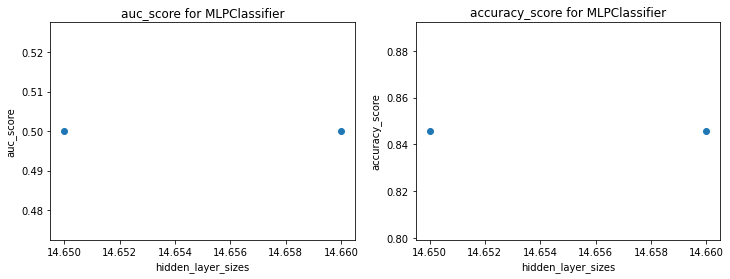

In [8]:
import warnings
warnings.filterwarnings('ignore')

args = {'max_iter':20, 'solver':'sgd','verbose':False,
        'tol':10**-6,'random_state':13, 'learning_rate_init':1,
        'learning_rate':'adaptive', 'alpha':0.01, }
hidden_layers_values = []
for d1 in range(165,167,1):
        for d2 in range(13,14,1):
                hidden_layers_values.append((d1,d2))
print(len(hidden_layers_values))

scoring = (auc_score, accuracy_score)
plot_scores(model_class=MLPClassifier,arg_name='hidden_layer_sizes', arg_values=hidden_layers_values,
other_args=args, xt=X_train, xv=X_val, yt=y_train, yv=y_val, tuple_index='both', scoring=scoring,plot_type='scatter')

In [ ]:
model = AdaBoostClassifier(n_estimators=10)
model.fit(X_train, y_train)
auc = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
print(auc)
accuracy_score(model, X_val, y_val)

calculating and plotting scores for AdaBoostClassifier:
DONE. best score:(25, 0.8901479007633588) achived by: (19, 0.9059117920836759)


[(19, 0.9059117920836759), (25, 0.8901479007633588)]

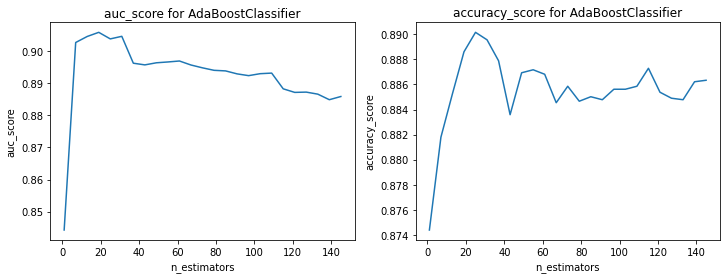

In [7]:
scoring = (auc_score, accuracy_score)



plot_scores(model_class=AdaBoostClassifier, arg_name='n_estimators',arg_values=[i for i in range(1,150,6)], scoring=scoring)

let's zoom in to the range 5-15

calculating and plotting scores for AdaBoostClassifier:
DONE. best score:(12, 0.8916984732824428) achived by: (8, 0.9047936336307533)


[(8, 0.9047936336307533), (12, 0.8916984732824428)]

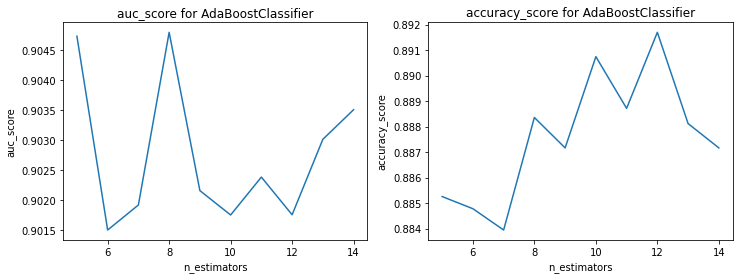

In [24]:
scoring = (auc_score, accuracy_score)

plot_scores(model_class=AdaBoostClassifier, arg_name='n_estimators',arg_values=[i for i in range(5,15,1)], scoring=scoring)

chosen: 8

In [ ]:
all_data  = pd.concat([X_train, X_val])
all_label  = pd.concat([y_train, y_val])
# validate_model()

In [ ]:
X_train.hist(figsize=(25,15))
pass

In [ ]:
X_train.hist(figsize=(25,15))
pass

# full pipeline


In [19]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [20]:
def id_prep(X, X_t):
    X = X.drop(columns=['id'])
    return X


def d_data_prep(X, X_t):
    return X.drop(columns=('D'))

def page_durations_prep(X, X_t):
    global avgs
    fields = ['info_page_duration', 'product_page_duration']
    for field in fields:
        print(field, 'str structure:', X[field].value_counts().index[0])

        # make sure all durations are in minutes
        print('not minutes count: ', len(X.loc[~X[field].str.contains('minutes').astype('bool'),(field)]))
        print('nan count: ', X[field].isnull().sum())

        # convert to float `type(d)==str ` handles nan values
        X[field] = [float(d.split()[0]) if type(d) is str else np.nan for d in X[field]]

        print('new types:')
        X.dtypes[fields]

    return X

avg_time_in_admin_page, avg_time_in_info_page, avg_time_in_product_page = (None, None, None)


def page_durations_fill_na(X, X_t):
    global avg_time_in_admin_page, avg_time_in_info_page, avg_time_in_product_page
    avg_time_in_admin_page = (X_t.admin_page_duration / X_t.num_of_admin_pages).mean()
    avg_time_in_info_page = (X_t.info_page_duration / X_t.num_of_info_pages).mean()
    avg_time_in_product_page = (X_t.product_page_duration / X_t.num_of_product_pages).mean()

    avgs = (avg_time_in_info_page, avg_time_in_product_page, avg_time_in_admin_page)
    duration_fields = ('info_page_duration', 'product_page_duration', 'admin_page_duration')
    num_of_fields = ('num_of_info_pages', 'num_of_product_pages','num_of_admin_pages')
    for i, field in enumerate(duration_fields):        
        num_of_field_copy = X[num_of_fields[i]].copy()
        num_of_field_copy = num_of_field_copy.fillna(num_of_field_copy.mean())
        X.loc[X[field].isna(), field] = avgs[i] * num_of_field_copy.loc[X[field].isna()]
    return X    

def total_druation_data_prep(X, X_t):
    computed_durations = X.admin_page_duration + X.info_page_duration + X.product_page_duration
    X.total_duration = X.total_duration.fillna(computed_durations)
    return X

def num_of_visits_data_prep(X: pd.DataFrame, X_t):
    global avg_time_in_admin_page, avg_time_in_info_page, avg_time_in_product_page
    avgs = (avg_time_in_info_page, avg_time_in_product_page, avg_time_in_admin_page)
    duration_fields = ('info_page_duration', 'product_page_duration', 'admin_page_duration')
    num_of_fields = ('num_of_info_pages', 'num_of_product_pages','num_of_admin_pages')
    for i, field in enumerate(num_of_fields):
        X.loc[X[field].isna(), field] = [ int(value / avgs[i]) for value in X.loc[X[field].isna(), duration_fields[i]]]
    return X


def rates_page_value_data_prep(X, X_t):    
    # so little nan values - lets fill with mean
    X.BounceRates = X.BounceRates.fillna(X_t.BounceRates.mean())
    X.ExitRates = X.ExitRates.fillna(X_t.ExitRates.mean())
    X.PageValues = X.PageValues.fillna(X_t.PageValues.mean())
    return X

def user_type_data_prep(X, X_t):
    RETURNING ='Returning_Visitor'
    X.user_type = [1 if u_type == RETURNING else 0 for u_type in X.user_type] 
    return X

def closeness_data_prep(X, X_t):    
    X.closeness_to_holiday = X.closeness_to_holiday.fillna(X_t.closeness_to_holiday.mean())
    return X

def make_dummy_C(X: pd.DataFrame, X_t):
    def extract_num(s):   
        if s is np.nan:
             return s
        for indx, chr in enumerate(s):
            if str.isdigit(chr):
                break
        return s[indx:]
    X.C = [extract_num(c) for c in X.C]

    return pd.get_dummies(data=X, columns=['C'], drop_first=False, prefix_sep='_dmy_')

def weekend_data_prep(X, X_t):
    X.Weekend = [1 if w else 0 for w in X.Weekend]
    return X

def b_data_prep(X, X_t):    
    X.B = X.B.fillna(X_t.B.mean())
    return X

def make_dummy_device(X: pd.DataFrame, X_t):
    mapper = {1.0: '1', 2.0: '2', 3.0: '3', 'Default': 'other'}
    X.device = [mapper.get(d, mapper['Default']) for d in X.device]    
    return pd.get_dummies(data=X, columns=['device'], drop_first=False, prefix_sep='_dmy_')
    

def browser_data_prep(X: pd.DataFrame, X_t):    
    X.internet_browser = X.internet_browser.str.replace('\d+', '')
    X['internet_browser'] = X['internet_browser'].astype(str).str.extract(r'([A-Za-z]+(?: [A-Za-z]+)*)')    
    X = pd.get_dummies(X,columns=['internet_browser'],drop_first=False, prefix_sep='_dmy_')    


    # device 1 means safari
    X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_1 > 0), ('internet_browser_dmy_safari',)] = 1

    # device 2/3 means chrome
    X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_2 + X.device_dmy_3  > 0), ('internet_browser_dmy_chrome',)] = 1

    print(X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_other == 1)].shape[0], ' nan values left. we shall fill it with chrome - chrome is the most common')

    # # fill with chrome
    X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_other == 1), 'internet_browser_dmy_chrome'] = 1

    # make sure no nan left 
    print(X.loc[(X.internet_browser_dmy_nan == 1) & ((X.internet_browser_dmy_chrome + X.internet_browser_dmy_safari) < 1)].shape[0], ' nan values left.')

    # drop nan dummy
    return X.drop(columns=['internet_browser_dmy_nan'])

def month_data_prep(X, X_t):
     Month_map = {'JAN':1, 'Feb':1, 'Mar':1, 'APR':2, 'May':2, 'June':2, 'Jul':3, 'Aug':3, 'Sep':3, 'Oct':4, 'Nov':4, 'Dec':4}
     X.Month = X.Month.map(Month_map)
     X.Month = X.Month.fillna(X_t.Month.median())
     return X

def region_data_prep(X: pd.DataFrame, X_t):
    train_median = np.median(X_t.Region[~X_t.Region.isnull()])
    X.Region = X.Region.fillna(train_median)
    return X

def a_data_prep(X,X_t):
    X.A = [np.nan if a is np.nan else float(str(a).split('_')[1]) for a in X.A]
    X.A = X.A.fillna(X_t.A.median())
    #X.A[X.A.isnull()] = train_median
    return X

def outlier_removal(X, X_t):
    column_mask = (~X.columns.str.contains('_dmy_') & ~X.columns.isin(['user_type', 'Weekend', 'Month', 'B']))
    max_trashold = X.loc[:,column_mask].quantile(q=0.95)
    min_trashold = X.loc[:,column_mask].quantile(q=0.05)

    no_outliers =  X.loc[:,column_mask]

    outlier_mask = ((no_outliers < min_trashold) | (no_outliers > max_trashold)).any(axis=1)

    mean = X_t.loc[:,column_mask].mean(axis=0).values.reshape(1,column_mask.sum())

    X.loc[outlier_mask,column_mask] = mean
    return X

def features_scaling(X, X_t):    
    dummy_features = [f for f in X_train.columns if ('_dmy_' in f)]

    minmax_scalar = MinMaxScaler()    
    minmax_mask = ~X.columns.isin(dummy_features)
    minmax_scalar.fit(X.loc[:,minmax_mask])
    X.loc[:,minmax_mask] = minmax_scalar.transform(X.loc[:,minmax_mask])

    return X 

In [21]:
save_print_func = print
data_prep_functions = [
    id_prep,d_data_prep, page_durations_prep, page_durations_fill_na, total_druation_data_prep, 
    num_of_visits_data_prep, rates_page_value_data_prep, user_type_data_prep ,closeness_data_prep, make_dummy_C,
    weekend_data_prep, b_data_prep,make_dummy_device, browser_data_prep, month_data_prep, region_data_prep, a_data_prep,
    # outlier_removal,
     features_scaling
]



def silent_print(*args, **kwargs):
    return
    

print = silent_print


data = pd.read_csv('train.csv')
Y = data.loc[:,'purchase'] 
X = data.iloc[:, :-1]
X_train, X_val, y_train, y_val = train_test_split(X, Y,test_size=0.8,random_state=23)

for prep in data_prep_functions:
    X_train = prep(X_train, X_train)
    X_val = prep(X_val, X_train)

all_data  = pd.concat([X_train, X_val])
all_label  = pd.concat([y_train, y_val])

print = save_print_func



In [22]:


def validate_data_prep(X):
    print(X.isna().sum().max() == 0)
    print(np.all(X.max() <= 1.01))
    print(np.all(X.min() >= -0.01))

# validate_data_prep(X_train)
# validate_data_prep(X_val)


In [23]:
from types import FunctionType

def validate_model(all_data, all_labels, model, model_name, num_folds=10):
    # 0.5 auc line
    baseline = [0,1]
    plt.plot(baseline, baseline, color='black', linestyle=':')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    


    # fpr would be the x axis. this is to calc mean auc between all iterations
    fpr_all_values = np.linspace(0,1,100) 
    tpr_sum = np.array([0.0]*100) 
    auc_sum = 0

    for train_mask, val_mask in KFold(num_folds, shuffle=True, random_state=13).split(X=all_data, y=all_labels):
        xt = all_data.iloc[train_mask] # x train
        xv = all_data.iloc[val_mask] # x validation
        yt = all_labels.iloc[train_mask] # y train
        yv = all_labels.iloc[val_mask] # y validation
        
        model.fit(xt, yt)

        fpr, tpr, thresholds = roc_curve(yv, model.predict_proba(xv)[:,1])
        plt.plot(fpr, tpr, color='lightpink')
        tpr_sum += np.interp(fpr_all_values, fpr, tpr)
        auc_sum += roc_auc_score(yv, model.predict_proba(xv)[:,1])
            

    plt.plot(fpr_all_values, tpr_sum / num_folds , color='darkred')
    plt.title(f'{model_name} result. AUC={round(auc_sum / num_folds, 5)}')
    


def auc_score(model, xv, yv):
    return max(
            roc_auc_score(yv, model.predict_proba(xv)[:,i])
            for i in (0,1))

def accuracy_score(model,xv,yv):
    return model.score(xv, yv)

def plot_scores(model_class, arg_name:str, arg_values:list,
            other_args:dict = None, xt=X_train, xv=X_val,
            yt=y_train, yv=y_val, tuple_index=0,
            scoring:FunctionType = auc_score, plot_type='plot'):
    """ for example :  
            plot_scores(model_class=MLPClassifier,arg_name='hidden_layer_sizes', arg_values=hidden_layers_values,
                        other_args=args, xt=X_train, xv=X_val, yt=y_train, yv=y_val, tuple_index='both', scoring=scoring,plot_type='scatter')"""
    print(f'calculating and plotting scores for {model_class.__name__}:')
    multiplot = False
    d = other_args or {} 
    scores = []
    best = 0
    for i, value in enumerate(arg_values):
        print(f'progress: [{int((i / len(arg_values)) * 100)}%]\r', end='')
        d[arg_name] = value
        model = model_class(**d)
        model.fit(xt, yt)
        if not hasattr(scoring, '__iter__'):
            scores.append(scoring(model, xv, yv))
        else:
            multiplot = True
            current_scores = []
            for score in scoring:
                current_scores.append(score(model,xv,yv))
            scores.append(current_scores)
    
   
    values = None
    # spaciel case for nural networks
    if type(tuple_index) is tuple:
        values = [i[tuple_index] for i in arg_values]
    elif type(tuple_index) is str:
        values = [float(i[1]) + i[0] / 100 for i in arg_values] 
    else:
        values = arg_values      


    # plotting
    if multiplot:
        figure, axes = plt.subplots(1,len(scoring))
        figure.set_size_inches((12,4))
        func_name_prefix = 'set_'
        scores = np.array(scores).T
        best_is = scores.argmax(axis=1)
        best = [(arg_values[best_index], scores[score_idnex][best_index]) for score_idnex, best_index in enumerate(best_is)]
    else:
        best_i = np.argmax(scores)
        best = arg_values[best_i], scores[best_i] 
        axes = [plt]
        scoring = [scoring]
        func_name_prefix = ''
        scores = [scores]

    for i,axe in enumerate(axes):
        axe.__getattribute__(plot_type)(values, scores[i])
        axe.__getattribute__ (func_name_prefix+'ylabel')(scoring[i].__name__)
        axe.__getattribute__ (func_name_prefix+'xlabel')(arg_name)
        axe.__getattribute__(func_name_prefix+'title')(f'{scoring[i].__name__} for {model_class.__name__}')
    print(f'DONE. best score:{best[1]} achived by: {best[0]}')
    return best
